In [1]:
from icp_warm_up.utils import icp, o3d_icp
from pr2_utils import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dataset = 20
with np.load(f"../data/Hokuyo{dataset}.npz") as data:
    lidar_ranges = data["ranges"].T       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans

with np.load(f"../data/odometry_imu_{dataset}.npz") as data:
    odometry = data["X"]
    odometry_stamp = data["stamps"]

f_odometry = InterpN1D(odometry_stamp, odometry)

(3, 3)


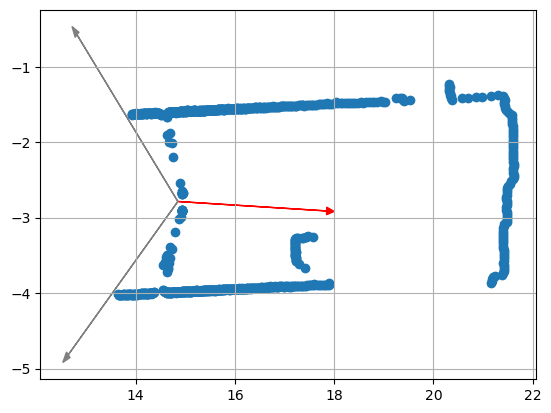

(3, 3)


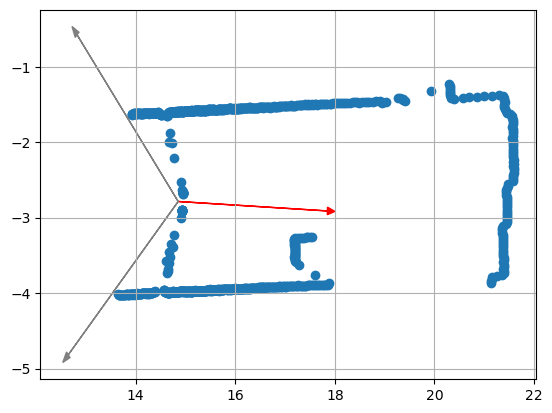

array([[ 9.99999997e-01, -7.08810859e-05,  0.00000000e+00,
         1.60547321e-02],
       [ 7.08810859e-05,  9.99999997e-01,  0.00000000e+00,
        -4.24817705e-04],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [4]:
plot_scan(lidar_ranges[1400], f_odometry(lidar_stamps[1400]))
plot_scan(lidar_ranges[1401], f_odometry(lidar_stamps[1400]))

o3d_icp(
    lidar_scan_to_3dpc(lidar_ranges[1401,:]),
    lidar_scan_to_3dpc(lidar_ranges[1400,:]),
)

In [5]:
n = lidar_stamps.shape[0]
T_scan = np.zeros([n,4,4])
T_scan[0] = np.eye(4)
T_odo = odometry_to_transformation(odometry)
sum_error = 0
for i in tqdm(range(1, n)):
    T_guess = diff_transformation(T_odo[i], T_odo[i-1])
    R, t, error = icp(
        lidar_scan_to_3dpc(lidar_ranges[i,:]),
        lidar_scan_to_3dpc(lidar_ranges[i-1,:]),
        *get_Rt(T_guess)
    )
    sum_error += error
    T_scan[i] = T_scan[i-1] @ get_T(R,t)
print(sum_error / n)
odometry_scan = transformation_to_odometry(T_scan)

100%|██████████| 4784/4784 [00:56<00:00, 83.99it/s] 

0.0025572324152040916


In [3]:
with np.load(f"../data/odometry_icp_{dataset}.npz") as data:
    odometry_scan = data["X"]

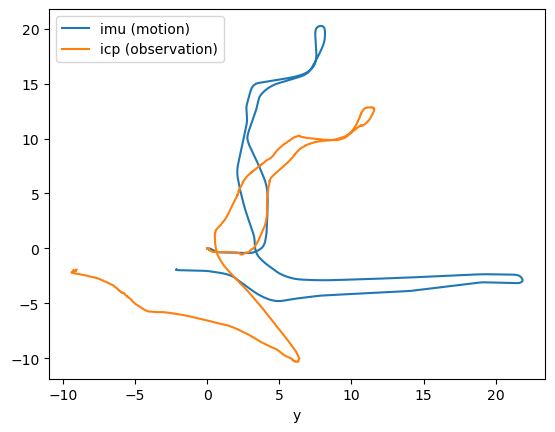

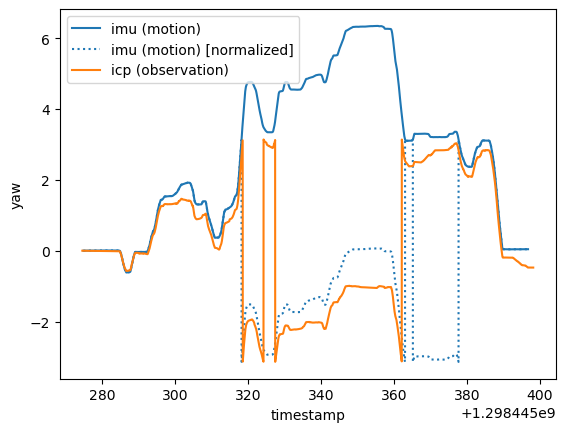

In [4]:
plot_odometry([
    (odometry,odometry_stamp, "imu (motion)"),
    (odometry_scan, lidar_stamps, "icp (observation)")
])

In [8]:
np.savez(f'../data/odometry_icp_{dataset}.npz', X=odometry_scan, stamps=lidar_stamps)